## Imports

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,
                                      StratifiedKFold,
                                    GridSearchCV)
import category_encoders as ce
from sklearn.preprocessing import StandardScaler,RobustScaler
from xgboost import (XGBClassifier,
                    plot_importance)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (train_test_split,
                                      StratifiedKFold,
                                    GridSearchCV,
                                    RandomizedSearchCV)
from sklearn.metrics import (mean_squared_error,
                             confusion_matrix,roc_curve,
                             classification_report,
                             roc_auc_score,
                             accuracy_score,
                             f1_score)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib

## Notebook Functions

In [4]:
# Get the item from the dict

def get_value(item):
    return item[1]

In [5]:
# Plot confusion matrix and roc side by side

def subplots_ROC_CM(main_title,rtitle,mtitle,mod,accuracy,auc,matrix,model,Xtest,ytest,label):
    fig , axes = plt.subplots(1,2,figsize=(10,8))


    y_pred_prob1_rs = mod.predict_proba(Xtest)[:,1]
    fpr1_rs, tpr1_rs, thresholds1_rs = roc_curve(ytest, y_pred_prob1_rs)
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].plot(fpr1_rs, tpr1_rs, label=label)
    axes[0].legend(loc="best")
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title(rtitle + "\n" +
             "AUC : {0:.2%}".format(auc.get(model)))

    group_names = ["TN", "FP","FN", "TP"]
    group_counts = ["{0:0.0f}".format(v) for v in matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value)
                     for value in matrix.flatten()/np.sum(matrix)]
    labels = [f"{name}\n{count}\n{percent}" for name, count, percent in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(matrix, annot=labels, fmt='',
                 cmap='Blues', ax=axes[1])
    axes[1].set_title(mtitle + "\n" + "Accuracy Score: {0:.2%}".format(accuracy.get(model)))
    axes[1].set_xlabel('\nPredicted Values')
    axes[1].set_ylabel('True Values')
    axes[1].xaxis.set_ticklabels(['0','1'])
    axes[1].yaxis.set_ticklabels(['0','1'])

    plt.suptitle(main_title,size=17, weight='bold')
    plt.show()


In [6]:
def booleanToInt(df,col):
    return df[col].map({' no': 0, ' yes': 1})

## Load Data

In [7]:
data = pd.read_csv('./data/raw/churn_all.csv')
data.head().T

,0,1,2,3,4
state,KS,OH,NJ,OH,OK
area_code,415,415,415,408,415
phone_number,382-4657,371-7191,358-1921,375-9999,330-6626
international_plan,no,no,no,yes,yes
voice_mail_plan,yes,yes,no,no,no
number_vmail_messages,25,26,0,0,0
total_day_minutes,265.1,161.6,243.4,299.4,166.7
total_day_calls,110,123,114,71,113
total_day_charge,45.07,27.47,41.38,50.9,28.34
total_eve_minutes,197.4,195.5,121.2,61.9,148.3


In [9]:
data.shape

(5000, 20)

In [10]:
# 70% train 25% val 5% tes
size_train = int(len(data) * 0.95)
size_test = int(len(data) * 0.05)

print(f"El tamaño de los datos de entrenamiento son {size_train} que constituye el 95% de los datos, \
y el tamaño de los datos de test es {size_test}.")

El tamaño de los datos de entrenamiento son 4750 que constituye el 95% de los datos, y el tamaño de los datos de test es 250.


In [11]:
assert len(data) == (size_test+size_train), "Proporciones del dataset incorrectas"

In [12]:
train_data = data.iloc[:size_train]
test_data = data.iloc[size_train:]

In [13]:
assert len(data) == (len(test_data)+len(train_data)), "Proporciones del dataset incorrectas"

In [14]:
X = train_data.drop(columns=['phone_number','Churn'])
y = train_data['Churn']
seed = 13

In [15]:
X.shape,y.shape

((4750, 18), (4750,))

In [16]:
y = y.astype(int)
y

0       0
1       0
2       0
3       0
4       0
       ..
4745    0
4746    0
4747    0
4748    0
4749    0
Name: Churn, Length: 4750, dtype: int64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=seed,
                                                    stratify=y)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3800, 18), (950, 18), (3800,), (950,))

## Preprocessing Data

In [19]:
X_train.head().T

,1977,4291,2807,727,2973
state,SC,SD,AK,NJ,NE
area_code,415,510,408,415,510
international_plan,yes,no,no,no,no
voice_mail_plan,no,no,no,no,no
number_vmail_messages,0,0,0,0,0
total_day_minutes,237.8,176.9,217.0,224.8,58.2
total_day_calls,92,75,104,111,96
total_day_charge,40.43,30.07,36.89,38.22,9.89
total_eve_minutes,208.9,204.2,152.3,190.0,202.1
total_eve_calls,119,86,83,101,126


In [20]:
print(X_train['international_plan'].unique())
print(X_train['voice_mail_plan'].unique())

[' yes' ' no']
[' no' ' yes']


In [21]:
X_train['international_plan'] = booleanToInt(X_train,'international_plan')
X_train['voice_mail_plan'] = booleanToInt(X_train,'voice_mail_plan')
X_test['international_plan'] = booleanToInt(X_test,'international_plan')
X_test['voice_mail_plan'] = booleanToInt(X_test,'voice_mail_plan')

In [22]:
X_train.head().T

,1977,4291,2807,727,2973
state,SC,SD,AK,NJ,NE
area_code,415,510,408,415,510
international_plan,1,0,0,0,0
voice_mail_plan,0,0,0,0,0
number_vmail_messages,0,0,0,0,0
total_day_minutes,237.8,176.9,217.0,224.8,58.2
total_day_calls,92,75,104,111,96
total_day_charge,40.43,30.07,36.89,38.22,9.89
total_eve_minutes,208.9,204.2,152.3,190.0,202.1
total_eve_calls,119,86,83,101,126


In [23]:
cat_cols = list(X_train.select_dtypes(include=[object]).columns)
cat_cols

['state']

In [24]:
num_cols = list(X_train.drop(columns='state').columns)
num_cols

['area_code',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls']

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

In [26]:
# The dataset is unbalanced, 14.18% of total target is True
y_train.value_counts(normalize=True)

Churn
0    0.858158
1    0.141842
Name: proportion, dtype: float64

## Feature Selection

In [27]:
neg, pos = np.bincount(y_train)
print(neg,pos)

scale_pos_weight = neg / pos
scale_pos_weight

3261 539


np.float64(6.050092764378479)

In [28]:
features = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
        random_state=seed
    ))
])

In [29]:
features.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [30]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3800 entries, 1977 to 2331
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          3800 non-null   object 
 1   area_code                      3800 non-null   int64  
 2   international_plan             3800 non-null   int64  
 3   voice_mail_plan                3800 non-null   int64  
 4   number_vmail_messages          3800 non-null   int64  
 5   total_day_minutes              3800 non-null   float64
 6   total_day_calls                3800 non-null   int64  
 7   total_day_charge               3800 non-null   float64
 8   total_eve_minutes              3800 non-null   float64
 9   total_eve_calls                3800 non-null   int64  
 10  total_eve_charge               3800 non-null   float64
 11  total_night_minutes            3800 non-null   float64
 12  total_night_calls              3800 non-null   int

In [31]:
# get the names from the columns OneHotEnoder

ohe = preprocessor.named_transformers_['cat']
cat_features = ohe.get_feature_names_out(cat_cols)
all_features = list(cat_features) + num_cols
all_features

['state_AK',
 'state_AL',
 'state_AR',
 'state_AZ',
 'state_CA',
 'state_CO',
 'state_CT',
 'state_DC',
 'state_DE',
 'state_FL',
 'state_GA',
 'state_HI',
 'state_IA',
 'state_ID',
 'state_IL',
 'state_IN',
 'state_KS',
 'state_KY',
 'state_LA',
 'state_MA',
 'state_MD',
 'state_ME',
 'state_MI',
 'state_MN',
 'state_MO',
 'state_MS',
 'state_MT',
 'state_NC',
 'state_ND',
 'state_NE',
 'state_NH',
 'state_NJ',
 'state_NM',
 'state_NV',
 'state_NY',
 'state_OH',
 'state_OK',
 'state_OR',
 'state_PA',
 'state_RI',
 'state_SC',
 'state_SD',
 'state_TN',
 'state_TX',
 'state_UT',
 'state_VA',
 'state_VT',
 'state_WA',
 'state_WI',
 'state_WV',
 'state_WY',
 'area_code',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_ch

In [32]:
xgb_model = features.named_steps['model']

gain_dict = xgb_model.get_booster().get_score(importance_type='gain')

feature_gain = {}
for i, feat in enumerate(all_features):
    f_key = f'f{i}'
    feature_gain[feat] = gain_dict.get(f_key, 0)

# --- Convertir a DataFrame y ordenar ---
df_gain = pd.DataFrame(list(feature_gain.items()), columns=['feature', 'gain'])
df_gain = df_gain.sort_values(by='gain', ascending=False).reset_index(drop=True)

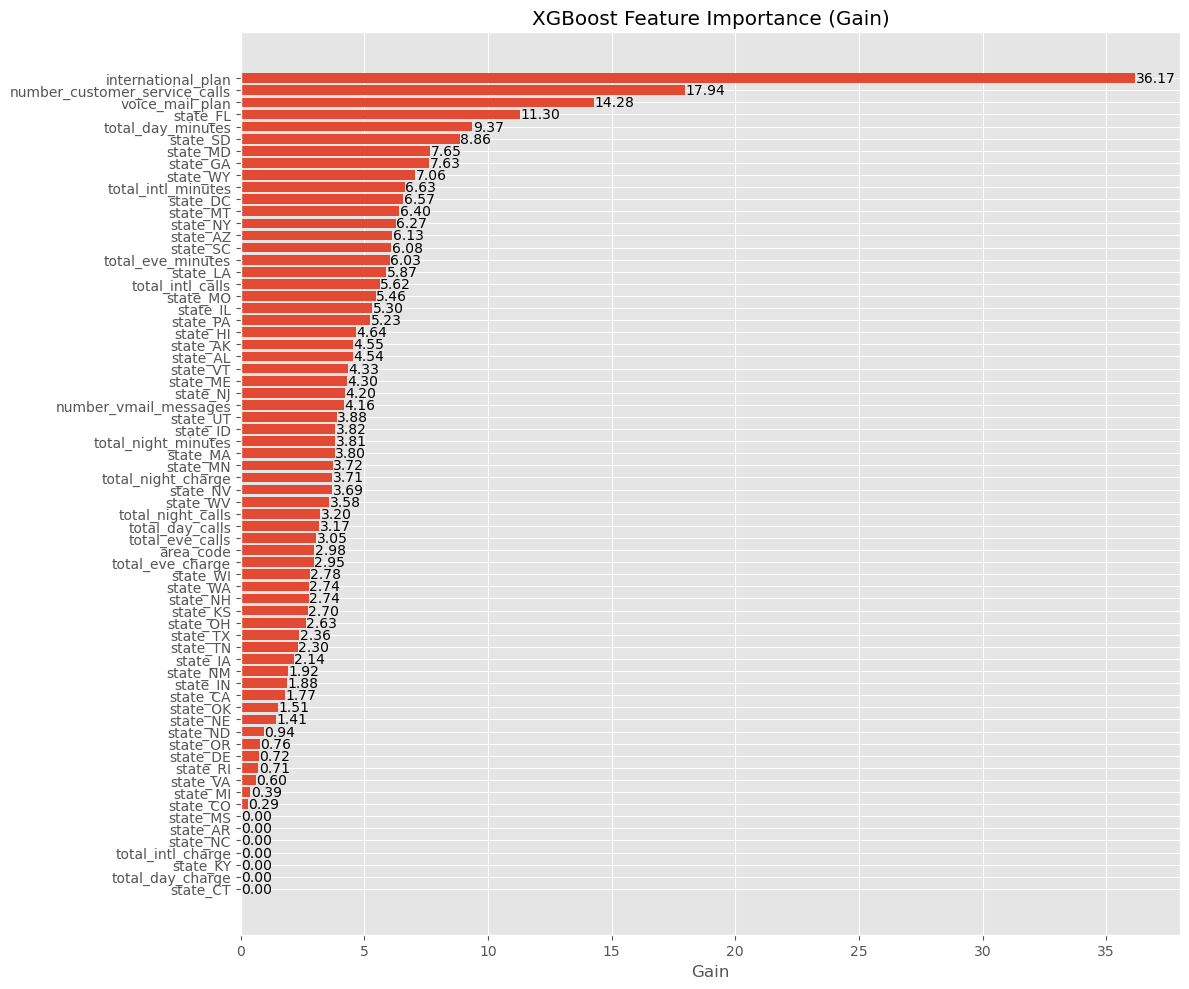

In [33]:
df_plot_gain = df_gain.sort_values(by='gain')

plt.figure(figsize=(12, 10))
bars = plt.barh(df_plot_gain['feature'], df_plot_gain['gain'])

plt.xlabel('Gain')
plt.title('XGBoost Feature Importance (Gain)')

# Añadir el valor al final de cada barra
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.02,                 
        bar.get_y() + bar.get_height() / 2,
        f'{width:.2f}',               
        va='center'
    )

plt.tight_layout()
plt.show()


# Calculate and plot different feature importance scores

In [34]:
most_important_features = df_gain[(df_gain.gain > 0) & (df_gain.gain >= 5) ]
most_important_features

,feature,gain
0,international_plan,36.174881
1,number_customer_service_calls,17.944674
2,voice_mail_plan,14.283168
3,state_FL,11.295585
4,total_day_minutes,9.365638
5,state_SD,8.861978
6,state_MD,7.648725
7,state_GA,7.629400
8,state_WY,7.062965
9,total_intl_minutes,6.628682


In [35]:
selected_columns = df_gain[(df_gain.gain > 0) & (df_gain.gain >= 5) ].feature
selected_columns

0                international_plan
1     number_customer_service_calls
2                   voice_mail_plan
3                          state_FL
4                 total_day_minutes
5                          state_SD
6                          state_MD
7                          state_GA
8                          state_WY
9                total_intl_minutes
10                         state_DC
11                         state_MT
12                         state_NY
13                         state_AZ
14                         state_SC
15                total_eve_minutes
16                         state_LA
17                 total_intl_calls
18                         state_MO
19                         state_IL
20                         state_PA
Name: feature, dtype: object

In this case, I will use the features that have a importance value greater than 5.

## Model Creation

### Random Forest

rf = RandomForestClassifier(random_state=seed,
                            class_weight='balanced',
                            n_jobs=-1)

In [36]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        random_state=seed,
        n_jobs=-1,
        class_weight='balanced'
    ))
])

In [37]:
# Hyperparameter Tuning
parameters_rf = {
    'model__n_estimators': [5,10,100, 200,500],
    'model__max_depth' : [None,2, 5, 7,10,20,25,35],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__criterion':['gini', 'entropy'],
    'model__bootstrap': [True, False]
}

In [38]:
skfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)

In [39]:
gridRf = gridRf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=parameters_rf,
    cv=skfold,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

In [40]:
gridRf.fit(X_train, y_train)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits
[CV] END model__bootstrap=True, model__criterion=gini, model__max_depth=None, model__min_samples_split=2, model__n_estimators=5; total time=   0.1s
[CV] END model__bootstrap=True, model__criterion=gini, model__max_depth=None, model__min_samples_split=2, model__n_estimators=10; total time=   0.3s
[CV] END model__bootstrap=True, model__criterion=gini, model__max_depth=None, model__min_samples_split=2, model__n_estimators=100; total time=   1.8s
[CV] END model__bootstrap=True, model__criterion=gini, model__max_depth=None, model__min_samples_split=2, model__n_estimators=100; total time=   1.7s
[CV] END model__bootstrap=True, model__criterion=gini, model__max_depth=None, model__min_samples_split=2, model__n_estimators=200; total time=   3.7s
[CV] END model__bootstrap=True, model__criterion=gini, model__max_depth=None, model__min_samples_split=2, model__n_estimators=500; total time=  10.1s
[CV] END model__bootstrap=True, model__

,estimator,Pipeline(step...m_state=13))])
,param_grid,"{'model__bootstrap': [True, False], 'model__criterion': ['gini', 'entropy'], 'model__max_depth': [None, 2, ...], 'model__min_samples_split': [2, 5, ...], ...}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...)]"


In [41]:
gridRf.best_score_

np.float64(0.9493232575457682)

In [42]:
# best parameters
gridRf.best_params_

{'model__bootstrap': False,
 'model__criterion': 'entropy',
 'model__max_depth': None,
 'model__min_samples_split': 10,
 'model__n_estimators': 500}

In [43]:
best_stimator_grid_rf = gridRf.best_estimator_
best_stimator_grid_rf

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [44]:
y_rf_pred = gridRf.predict(X_test)

In [45]:
report_rf = classification_report(y_test, y_rf_pred,output_dict=True)
df_report_rf = pd.DataFrame(report_rf).T
df_report_rf

,precision,recall,f1-score,support
0,0.967587,0.988957,0.978155,815.000000
1,0.923077,0.800000,0.857143,135.000000
accuracy,0.962105,0.962105,0.962105,0.962105
macro avg,0.945332,0.894479,0.917649,950.000000
weighted avg,0.961262,0.962105,0.960959,950.000000


In [46]:
#Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_rf_pred)
conf_matrix_rf

array([[806,   9],
       [ 27, 108]])

In [47]:
#Accuracy
acu_rf = accuracy_score(y_test, y_rf_pred)
acu_rf

0.9621052631578947

In [48]:
#AUC
auc_rf = roc_auc_score(y_test, y_rf_pred)
auc_rf

0.8944785276073619

In [49]:
acmod_rf = {"RF_y_test":round(acu_rf,4)}
aucmod_rf = {"RF_y_test":round(auc_rf,4)}

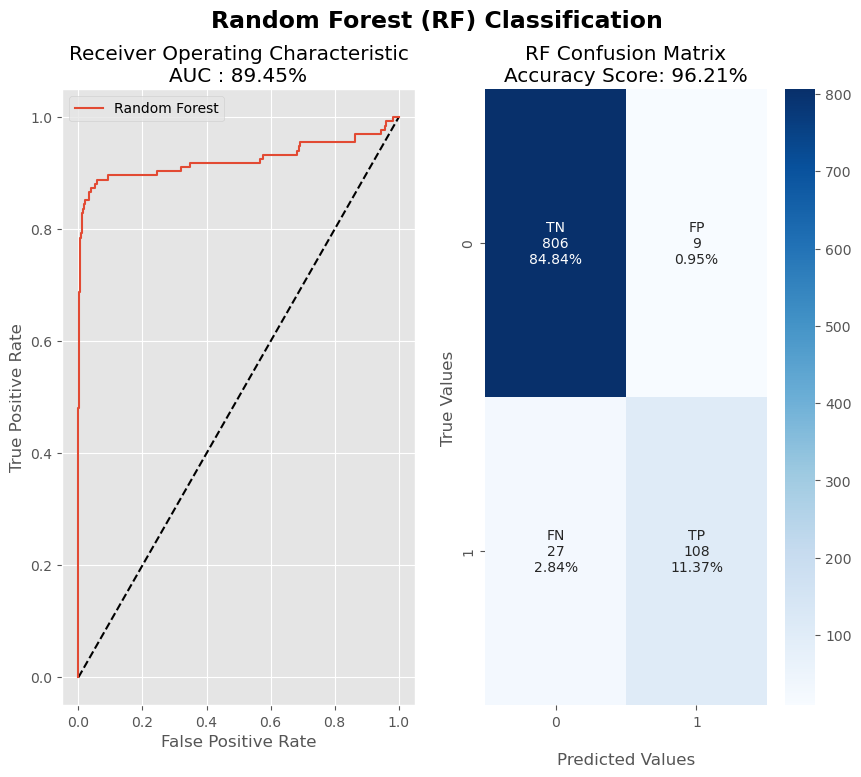

In [50]:
#Plot ROC curve and Confusion matrix
subplots_ROC_CM("Random Forest (RF) Classification",
                "Receiver Operating Characteristic",
                "RF Confusion Matrix",
                gridRf.best_estimator_,
                acmod_rf,
                aucmod_rf,
                conf_matrix_rf,
                "RF_y_test",
                X_test,
                y_test,
                "Random Forest")

### XGBoost

In [51]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=seed,
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1
    ))
])

In [52]:
# Hyperparameter Tuning
parameters_xgbc = {
              'model__learning_rate': [0.001,0.01,0.05,0.1],
              'model__max_depth': [2,3,4,7,10],
              'model__subsample': [0.6, 0.8, 1.0],
              'model__colsample_bytree': [0.3,0.5,0.7,1.0],
              'model__n_estimators': [200,250,500,1000],
              'model__min_child_weight': [1, 5, 10],
              'model__gamma': [0, 0.1, 0.3,1,5],
              'model__reg_alpha': [0, 0.1],
              'model__reg_lambda': [1, 1.5]
  
}

In [53]:
gridXgbc = RandomizedSearchCV(
            estimator=xgb_pipeline,
            param_distributions=parameters_xgbc,
            n_iter=30,
            cv=skfold,
            scoring='f1_weighted',
            random_state=seed,
            n_jobs=-1,
            verbose=2
        )

In [54]:
gridXgbc.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END model__bootstrap=False, model__criterion=entropy, model__max_depth=20, model__min_samples_split=20, model__n_estimators=100; total time=   3.5s
[CV] END model__bootstrap=False, model__criterion=entropy, model__max_depth=20, model__min_samples_split=20, model__n_estimators=100; total time=   3.6s
[CV] END model__bootstrap=False, model__criterion=entropy, model__max_depth=20, model__min_samples_split=20, model__n_estimators=200; total time=   6.8s
[CV] END model__bootstrap=False, model__criterion=entropy, model__max_depth=20, model__min_samples_split=20, model__n_estimators=500; total time=  15.3s
[CV] END model__bootstrap=False, model__criterion=entropy, model__max_depth=20, model__min_samples_split=20, model__n_estimators=500; total time=  15.0s
[CV] END model__bootstrap=False, model__criterion=entropy, model__max_depth=25, model__min_samples_split=2, model__n_estimators=200; total time=   7.0s
[CV] END model__boots

,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'model__colsample_bytree': [0.3, 0.5, ...], 'model__gamma': [0, 0.1, ...], 'model__learning_rate': [0.001, 0.01, ...], 'model__max_depth': [2, 3, ...], ...}"
,n_iter,30
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,13
,error_score,nan


In [55]:
gridXgbc.best_score_

np.float64(0.9518635183591064)

In [56]:
#best parameters
gridXgbc.best_params_

{'model__subsample': 0.8,
 'model__reg_lambda': 1.5,
 'model__reg_alpha': 0.1,
 'model__n_estimators': 500,
 'model__min_child_weight': 5,
 'model__max_depth': 7,
 'model__learning_rate': 0.05,
 'model__gamma': 0.1,
 'model__colsample_bytree': 0.7}

In [57]:
best_estimator_grid_xgbc = gridXgbc.best_estimator_
best_estimator_grid_xgbc

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [58]:
y_xgbc_pred = gridXgbc.predict(X_test)

In [59]:
report_xgbc = classification_report(y_test, y_xgbc_pred,output_dict=True)
df_report_xgbc = pd.DataFrame(report_xgbc).T
df_report_xgbc

,precision,recall,f1-score,support
0,0.975669,0.984049,0.979841,815.000000
1,0.898438,0.851852,0.874525,135.000000
accuracy,0.965263,0.965263,0.965263,0.965263
macro avg,0.937053,0.917950,0.927183,950.000000
weighted avg,0.964694,0.965263,0.964875,950.000000


In [60]:
#Confusion matrix
conf_matrix_xgbc = confusion_matrix(y_test, y_xgbc_pred)
conf_matrix_xgbc

array([[802,  13],
       [ 20, 115]])

In [61]:
#Accuracy
acu_xgbc = accuracy_score(y_test, y_xgbc_pred)
acu_xgbc

0.9652631578947368

In [62]:
#AUC
auc_xgbc = roc_auc_score(y_test, y_xgbc_pred)
auc_xgbc

0.9179504658032266

In [63]:
acmod_xgbc = {"XGBC_y_test":round(acu_xgbc,4)}
aucmod_xgbc = {"XGBC_y_test":round(auc_xgbc,4)}

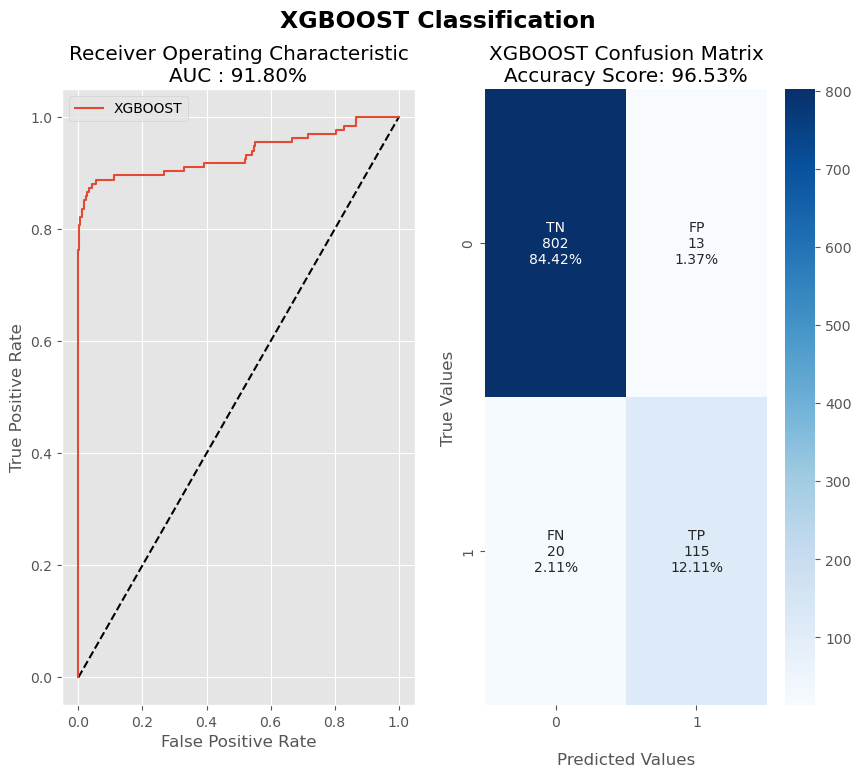

In [64]:
# Plot the ROC curve and confusion matrix
subplots_ROC_CM("XGBOOST Classification",
                "Receiver Operating Characteristic",
                "XGBOOST Confusion Matrix",
                gridXgbc.best_estimator_,
                acmod_xgbc,
                aucmod_xgbc,
                conf_matrix_xgbc,
                "XGBC_y_test",
                X_test,
                y_test,
                "XGBOOST")

### Model Selection

In [65]:
Accuracy = {"RF":acu_rf,"XGBC":acu_xgbc}
AUC = {"RF":auc_rf,"XGBC":auc_xgbc}
F1_score = {"RF":df_report_rf.iloc[3,2],
           "XGBC":df_report_xgbc.iloc[3,2]}

In [66]:
metrics_models = pd.DataFrame([Accuracy,AUC,F1_score],index=["Accuracy","AUC","F1"]).T
metrics_models

,Accuracy,AUC,F1
RF,0.962105,0.894479,0.917649
XGBC,0.965263,0.917950,0.927183


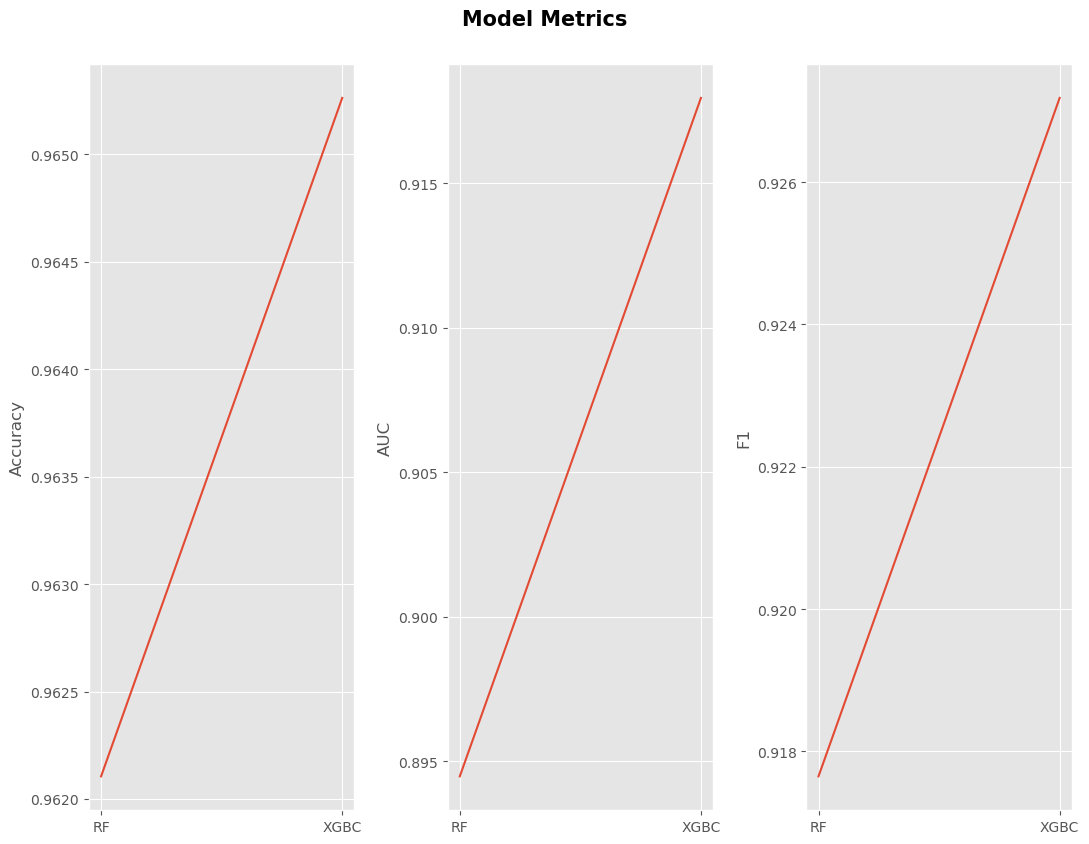

In [67]:
fig,axes= plt.subplots(1,3,figsize=(11,8))

for i,col in enumerate(metrics_models.columns):
    sns.lineplot(data=metrics_models[col],ax=axes[i] )

plt.tight_layout()
plt.suptitle("Model Metrics", fontsize = 15, fontweight = "bold", y=1.05)
plt.savefig('model_metrics.png',bbox_inches='tight')
plt.show()

In [68]:
false_Negative = [conf_matrix_rf[1,0],
                 conf_matrix_xgbc[1,0]]
false_Negative_S = pd.Series(false_Negative,name="FN",index=["RF","XGBC"])

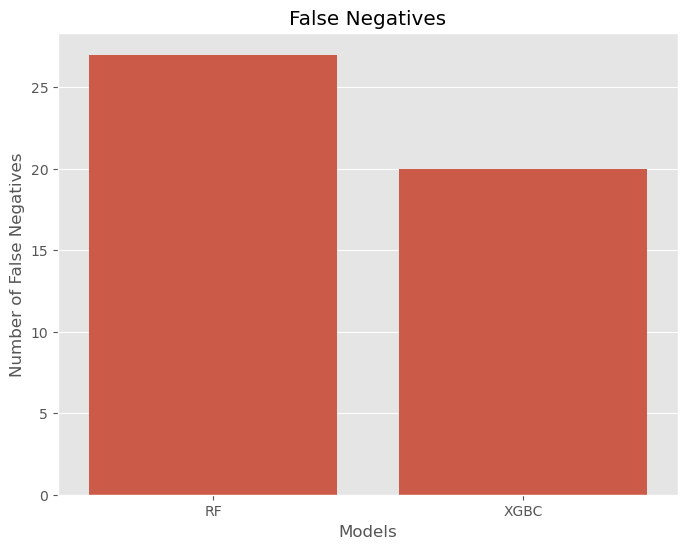

In [69]:
fig  = plt.figure(figsize=(8, 6))
sns.barplot(x=false_Negative_S.index,y=false_Negative_S.values)
plt.ylabel("Number of False Negatives")
plt.xlabel("Models")
plt.title("False Negatives")
plt.savefig('false_negatives.png',bbox_inches='tight')
plt.show()

The models obtain very similar results, but in this case, the Random Forest model produces one fewer false negative than the XGBoost Classifier, which can have a significant impact in the long term.

## Test the model

In [70]:
test_data.head().T

,4750,4751,4752,4753,4754
state,AL,WV,NM,IN,NE
area_code,408,415,415,510,408
phone_number,392-5428,354-8345,334-2938,406-4649,396-5467
international_plan,no,no,no,no,no
voice_mail_plan,no,no,no,no,no
number_vmail_messages,0,0,0,0,0
total_day_minutes,207.0,243.4,157.4,233.9,195.4
total_day_calls,94,76,89,76,71
total_day_charge,35.19,41.38,26.76,39.76,33.22
total_eve_minutes,256.3,161.4,196.0,153.2,249.4


In [72]:
Xtest = test_data.drop(columns=['phone_number','Churn'])
yTest = test_data.Churn

In [73]:
Xtest['international_plan'] = booleanToInt(Xtest,'international_plan')
Xtest['voice_mail_plan'] = booleanToInt(Xtest,'voice_mail_plan')

In [74]:
y_test_pred = gridXgbc.predict(Xtest)
y_test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0])

In [75]:
report_test = classification_report(yTest, y_test_pred,output_dict=True)
df_report_test = pd.DataFrame(report_test).T
df_report_test

,precision,recall,f1-score,support
False,0.986175,0.986175,0.986175,217.000
True,0.909091,0.909091,0.909091,33.000
accuracy,0.976000,0.976000,0.976000,0.976
macro avg,0.947633,0.947633,0.947633,250.000
weighted avg,0.976000,0.976000,0.976000,250.000


In [76]:
#Confusion matrix
conf_matrix_test = confusion_matrix(yTest, y_test_pred)
conf_matrix_test

array([[214,   3],
       [  3,  30]])

In [77]:
#Accuracy
acu_test = accuracy_score(yTest, y_test_pred)
acu_test

0.976

In [78]:
#AUC
auc_test = roc_auc_score(yTest, y_test_pred)
auc_test

0.9476330121491411

In [79]:
acmod_test = {"XGBC_y_test":round(acu_test,4)}
aucmod_test = {"XGBC_y_test":round(auc_test,4)}

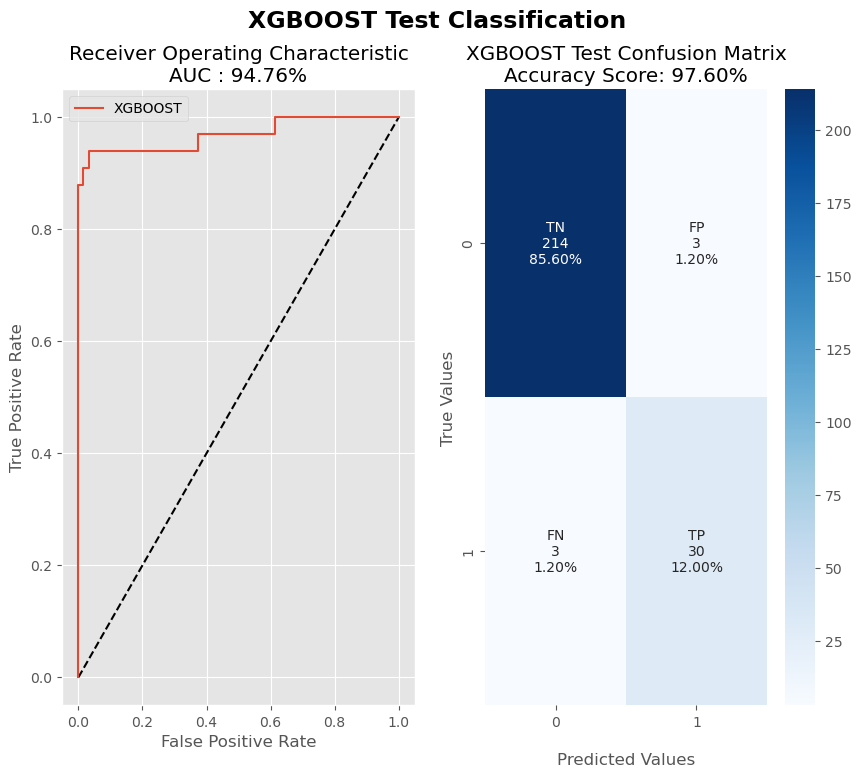

In [80]:
# Plot the ROC curve and confusion matrix
subplots_ROC_CM("XGBOOST Test Classification",
                "Receiver Operating Characteristic",
                "XGBOOST Test Confusion Matrix",
                gridXgbc.best_estimator_,
                acmod_test,
                aucmod_test,
                conf_matrix_test,
                "XGBC_y_test",
                Xtest,
                yTest,
                "XGBOOST")

## Save model

In [81]:
joblib.dump(best_estimator_grid_xgbc, "./model/churn_model_pipeline.pkl")

['./model/churn_model_pipeline.pkl']

## Load Model

In [3]:
XGB_model = joblib.load("./model/churn_model_pipeline.pkl")

## Important Remarks

* **Understanding the key characteristics of customers who are likely to churn.**

| Rank | Feature                         | Gain (%) |
|------|---------------------------------|------|
| 1    | international_plan              | 36.17 |
| 2    | number_customer_service_calls   | 17.94 |
| 3    | voice_mail_plan                 | 14.28 |
| 4    | state_FL                        | 11.30 |
| 5    | total_day_minutes               | 9.37 |
| 6    | state_SD                        | 8.86 |
| 7    | state_MD                        | 7.65 |
| 8    | state_GA                        | 7.63 |
| 9    | state_WY                        | 7.06 |
| 10   | total_intl_minutes              | 6.63 |
| 11   | state_DC                        | 6.57 |
| 12   | state_MT                        | 6.40 |
| 13   | state_NY                        | 6.27 |
| 14   | state_AZ                        | 6.13 |
| 15   | state_SC                        | 6.08 |
| 16   | total_eve_minutes               | 6.03 |
| 17   | state_LA                        | 5.87 |
| 18   | total_intl_calls                | 5.62 |
| 19   | state_MO                        | 5.46 |
| 20   | state_IL                        | 5.30 |
| 21   | state_PA                        | 5.23 |


* Predicting the customer’s likelihood of leaving (churning).

In [85]:
customer_ids = data['phone_number']
all_customer_data = data.drop(columns=['phone_number','Churn'])
all_customer_churn = data.Churn

In [87]:
all_customer_data['international_plan'] = booleanToInt(all_customer_data,'international_plan')
all_customer_data['voice_mail_plan'] = booleanToInt(all_customer_data,'voice_mail_plan')

In [89]:
all_customer_predictions = gridXgbc.predict(all_customer_data)
all_customer_proba = gridXgbc.predict_proba(all_customer_data)[:,1]

In [92]:
df_customer_results = pd.DataFrame({
    'phone_number': customer_ids,
    'churn_proba': all_customer_proba,
    'Churn':all_customer_churn
})
df_customer_results

,phone_number,churn_proba,Churn
0,382-4657,0.001996,False
1,371-7191,0.037572,False
2,358-1921,0.003210,False
3,375-9999,0.441994,False
4,330-6626,0.013747,False
...,...,...,...
4995,365-8751,0.032293,False
4996,334-9736,0.023600,True
4997,333-6861,0.043815,False
4998,394-2206,0.012286,False


* Identifying the top 500 customers to contact first – maximizing profitability and minimizing churn.


In [93]:
top_500 = df_customer_results.sort_values('churn_proba', ascending=False).head(500)
top_500

,phone_number,churn_proba,Churn
985,345-9140,0.999929,True
2113,335-2967,0.999809,True
2099,419-5171,0.999803,True
2401,352-7752,0.999773,True
3132,394-5489,0.999754,True
...,...,...,...
4421,340-6397,0.965833,True
3151,385-5688,0.965799,True
1954,373-8483,0.965743,True
99,362-9748,0.965590,True


* Evaluating how your strategy compares to randomly contacting the business’ customers.

In [94]:
# Number of clients
N = 500

# ML strategy
top_model = df_customer_results.sort_values('churn_proba', ascending=False).head(N)
churners_model = top_model['Churn'].sum()
print(f"Churners captured by model: {churners_model} / {N}")

# Random strategy
top_random = df.sample(N, random_state=seed)
churners_random = top_random['Churn'].sum()
print(f"Churners captured by random: {churners_random} / {N}")

# Lift
lift = churners_model / churners_random
print(f"Lift over random: {lift:.2f}x")

Churners captured by model: 500 / 500
Churners captured by random: 71 / 500
Lift over random: 7.04x


The model provides an efficient and targeted retention strategy, allowing the company to focus its resources on customers most likely to churn, improving the impact of retention compared to a random approach.

Demonstrating that the churn model is seven times more effective than selecting customers at random, making it a more efficient strategy.